In [1]:
%reload_ext autoreload
import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules

from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter
from hadamard_bench import *
from pyquil import get_qc
from quil_utils import *

import json
import pandas as pd
import seaborn as sns

from Noise_siumulator_Aspen_M2 import simulate_noise_aspen_m_2

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']


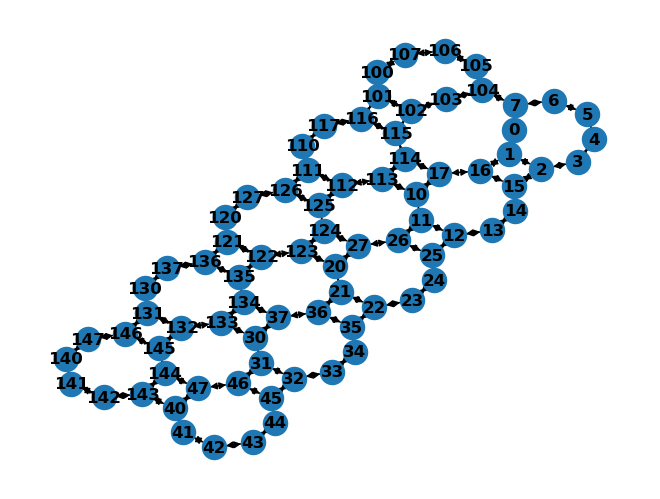

In [3]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
#ion_q = LocalSimulator()

ds = DeviceScanner( device = rigetti)

ds.list_properties()

In [14]:
shots = 1000
#set_n_qubits = range(3,10)
n_qubits = 11
set_line_length = [10,20,30,50,100]
print(set_line_length)

[10, 20, 30, 50, 100]


1000 shots 11 qubits tasks Rigetti


In [4]:
rigetti_tasks = []
labels = []

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'Rigetti')
    circ = Circuit().add_verbatim_box(circ)
   
    rigetti_task = rigetti.run(circ,shots=shots,disable_qubit_rewiring=True)
    rigetti_tasks.append(rigetti_task)
    labels.append( "rigetti_s1000_q11_hl" + str(line_length))

10


NameError: name 'rigetti' is not defined

In [15]:
dump_tasks(rigetti_tasks, labels, filename = "H_line_rigetti_grosso")

In [15]:
tasks = load_tasks("H_line_rigetti_grosso")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


1000 shots 11 qubits tasks IonQ

In [10]:
ionq_tasks = []
labels = []

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'IonQ')
    circ = Circuit().add_verbatim_box(circ)
   
    ionq_task = ion_q.run(circ,shots=shots)
    ionq_tasks.append(ionq_task)
    labels.append( "ionq_s1000_q11_hl" + str(line_length))

10
20
30
50
100


In [ ]:
dump_tasks(ionq_tasks, labels, filename = "H_line_ionq_grosso")

In [14]:
tasks = load_tasks("H_line_ionq_grosso")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['QUEUED', 'QUEUED', 'QUEUED', 'QUEUED', 'QUEUED']


## Analisi Risultati


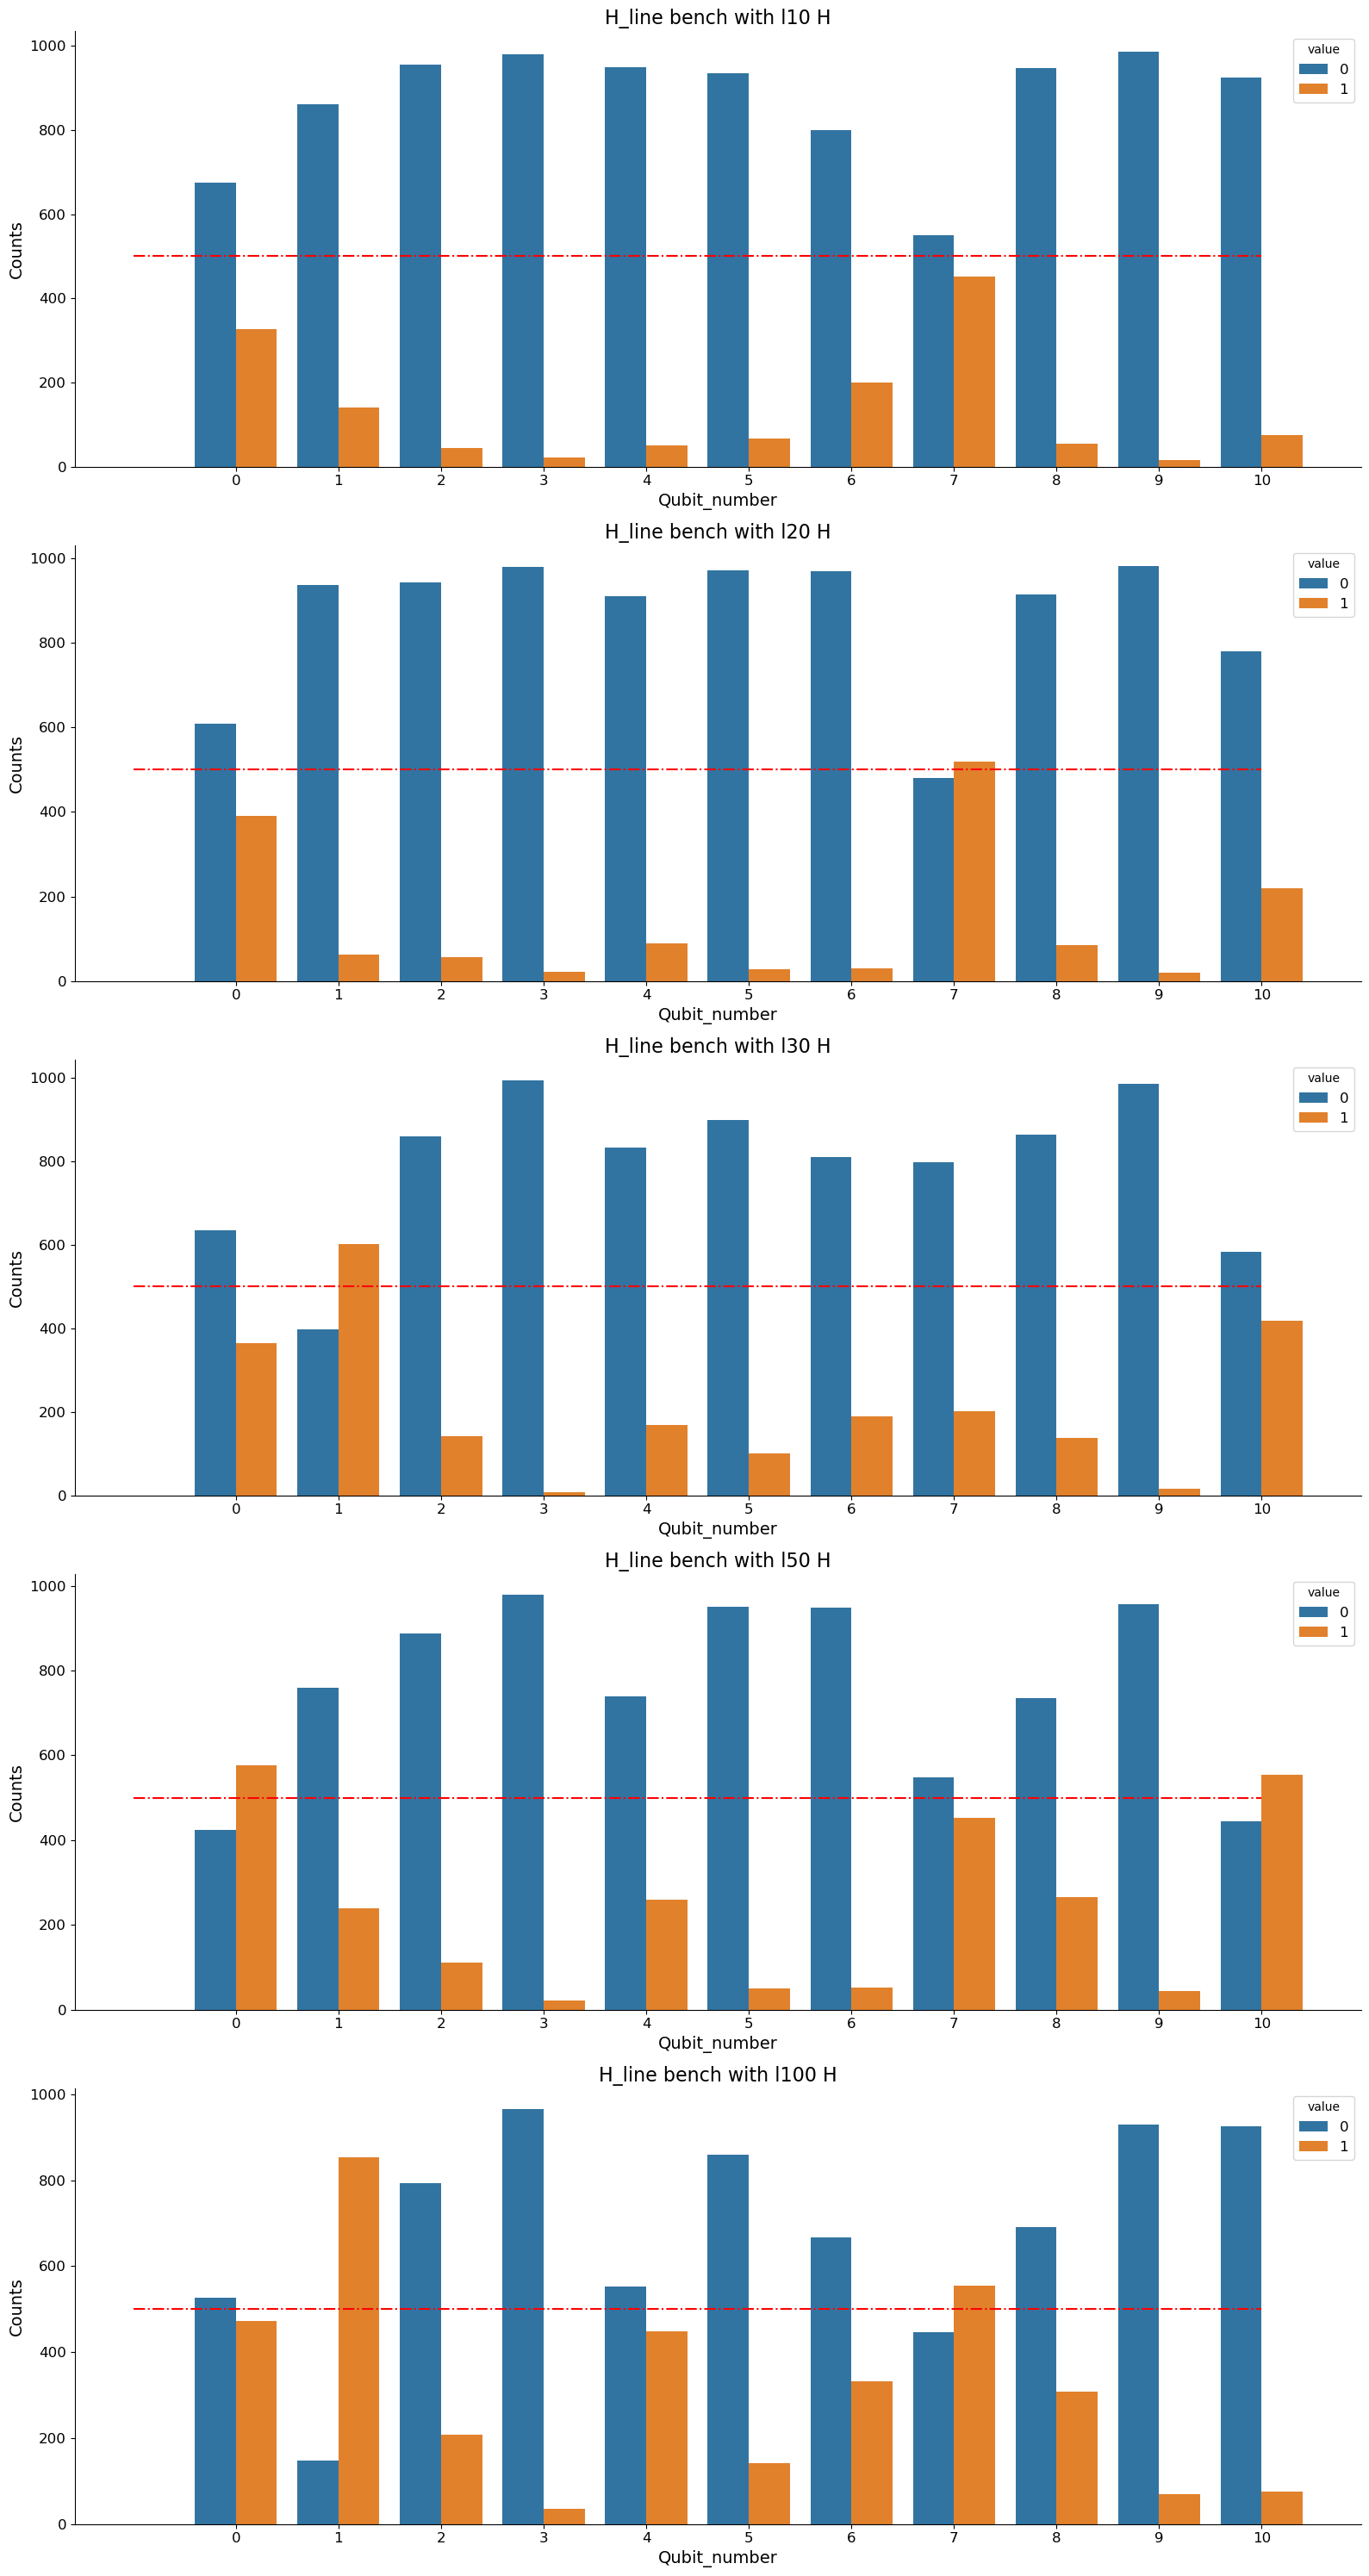

In [12]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):

    H_len = key.split("_")[-1][1:]
    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    ax.set_title(f'H_line bench with {H_len} H')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')

In [16]:
qubit_mappings = [get_rigetti_compilation_map(scanner.get_compiled_circuit()) for scanner in scanners]

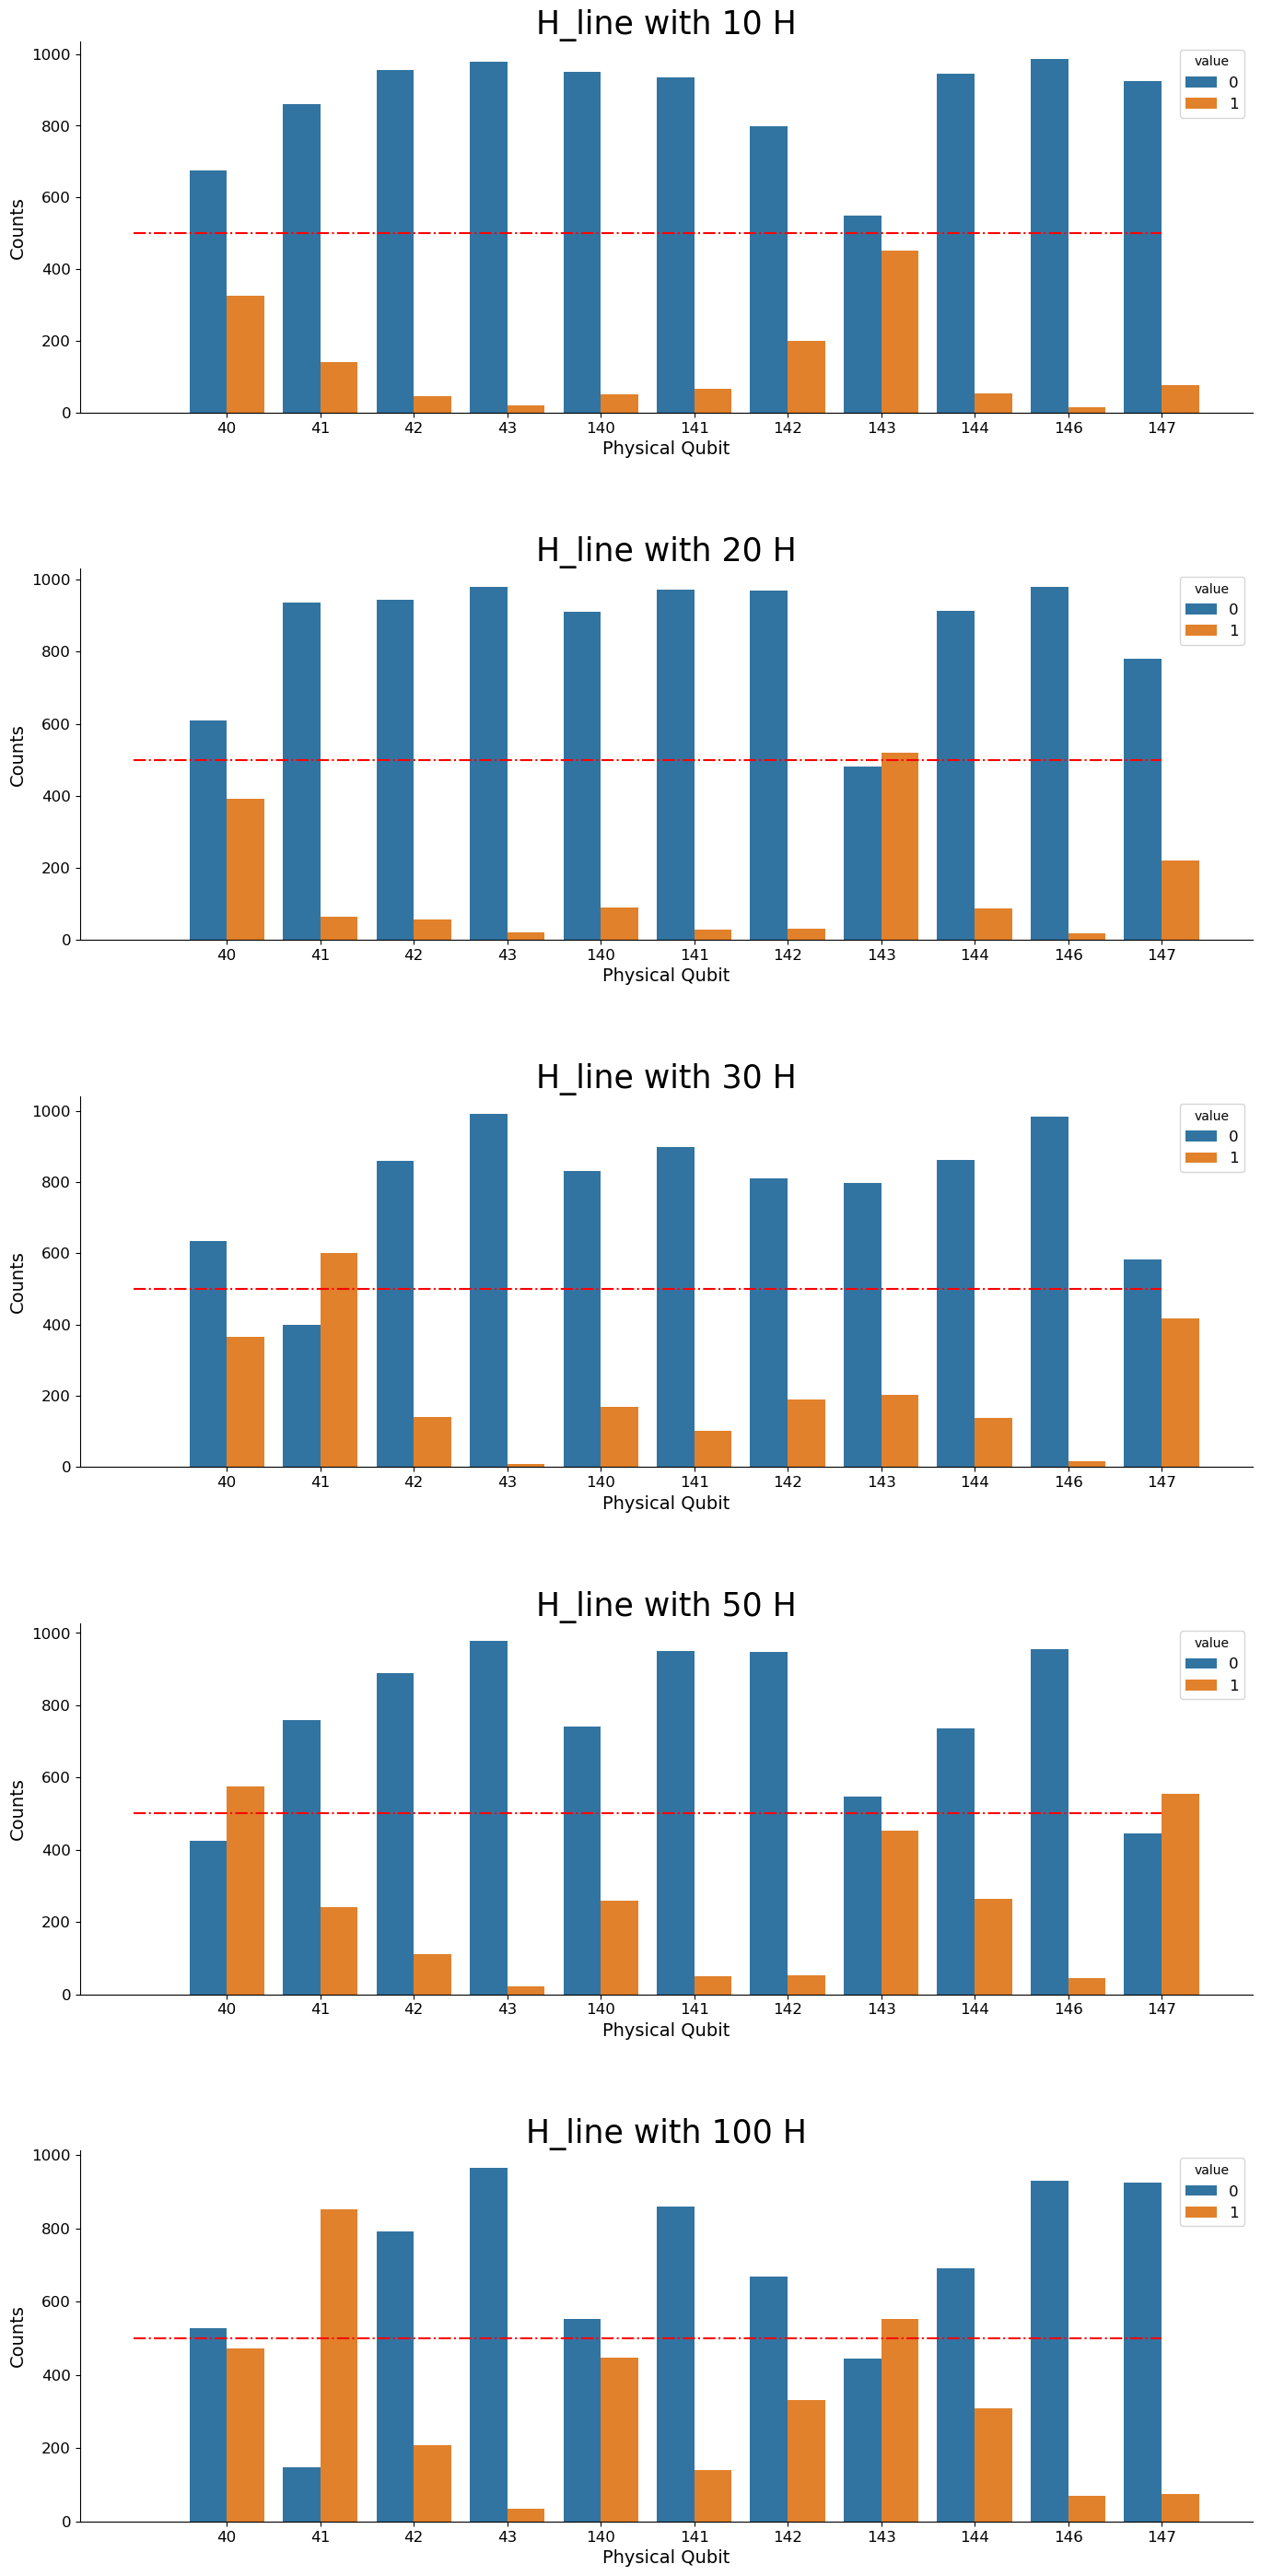

In [41]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):

    H_len = int(key.split("_")[-1][2:])

    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'H_line with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')
    ax.set_xticklabels([qubit_mappings[i][x] for x in range(n_qubits)])
    i+=1

# Analisi dei Qubit peggiori

In [3]:
shots = 1000
worst_qubits = [40,42]
set_line_length = [20,100]

In [ ]:
rigetti_tasks = []
labels = []

for qubit_n in worst_qubits:
    for line_length in set_line_length:
        print(line_length)

        circ = Circuit().H_line([qubit_n],line_length,'Rigetti')
        circ = Circuit().add_verbatim_box(circ)

        rigetti_task = rigetti.run(circ,shots=shots,disable_qubit_rewiring=True)
        rigetti_tasks.append(rigetti_task)
        labels.append( "rigetti_s1000_q" + str(qubit_n)+"_hl" + str(line_length))
        

In [ ]:
dump_tasks(ionq_tasks, labels, filename = "H_line_rigetti_schifo.json")

In [14]:
tasks = load_tasks("H_line_rigetti_schifo.json")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['QUEUED', 'QUEUED', 'QUEUED', 'QUEUED', 'QUEUED']


## Analisi Risultati


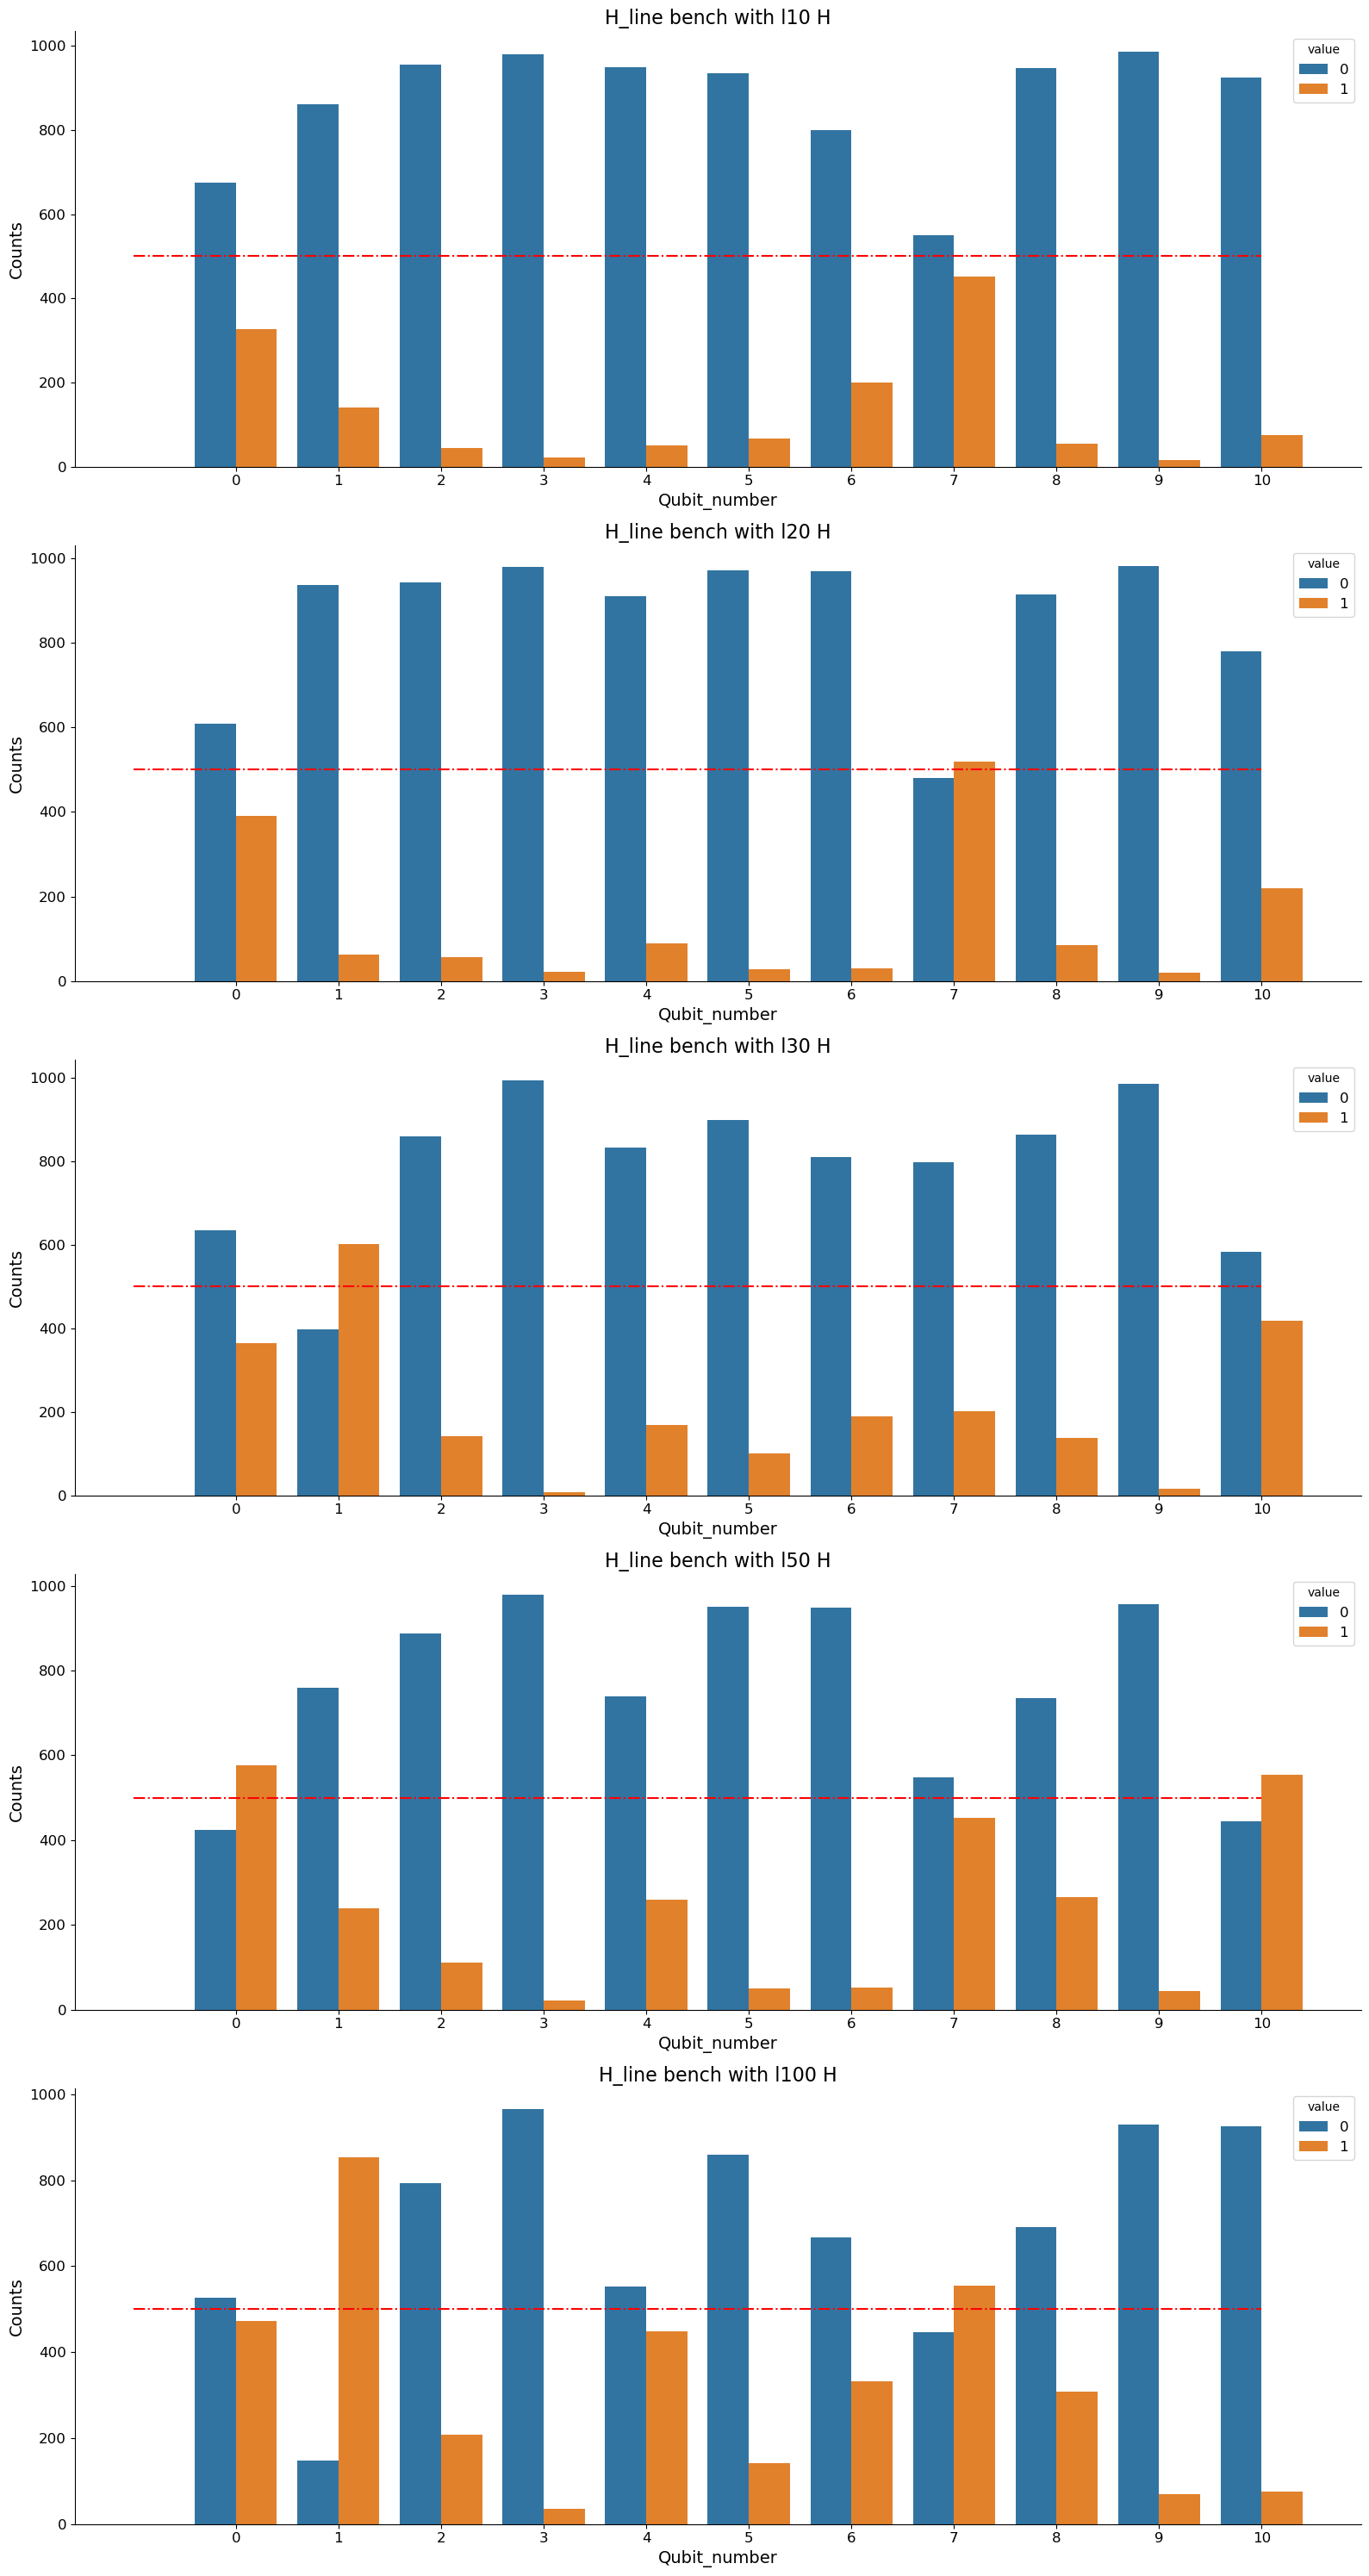

In [12]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):

    H_len = key.split("_")[-1][1:]
    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    ax.set_title(f'H_line bench with {H_len} H')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')

# Confronto con le simulazioni

In [5]:
local_simulator = DeviceUtils.get_device('dm1')

In [36]:
circuits =[Quil_to_Braket_Transpiler(scanner.get_compiled_circuit(),quil_rewiring=True).braket_circ for scanner in scanners]
simulation_tasks = []
labels = []
qubit_mappings_sim = []
for i,line_length in enumerate(set_line_length):
    print(line_length)
    
    circ = circuits[i]
    noisy_circ,qubit_mapping = simulate_noise_aspen_m_2(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=shots)
    
    simulation_tasks.append(simulation_task)
    qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_s1000_q11_hl_" + str(line_length))

10
20
30
50
100


In [37]:
dump_tasks(simulation_tasks, labels, filename = "H_line_l_s_grosso.json")

In [42]:
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


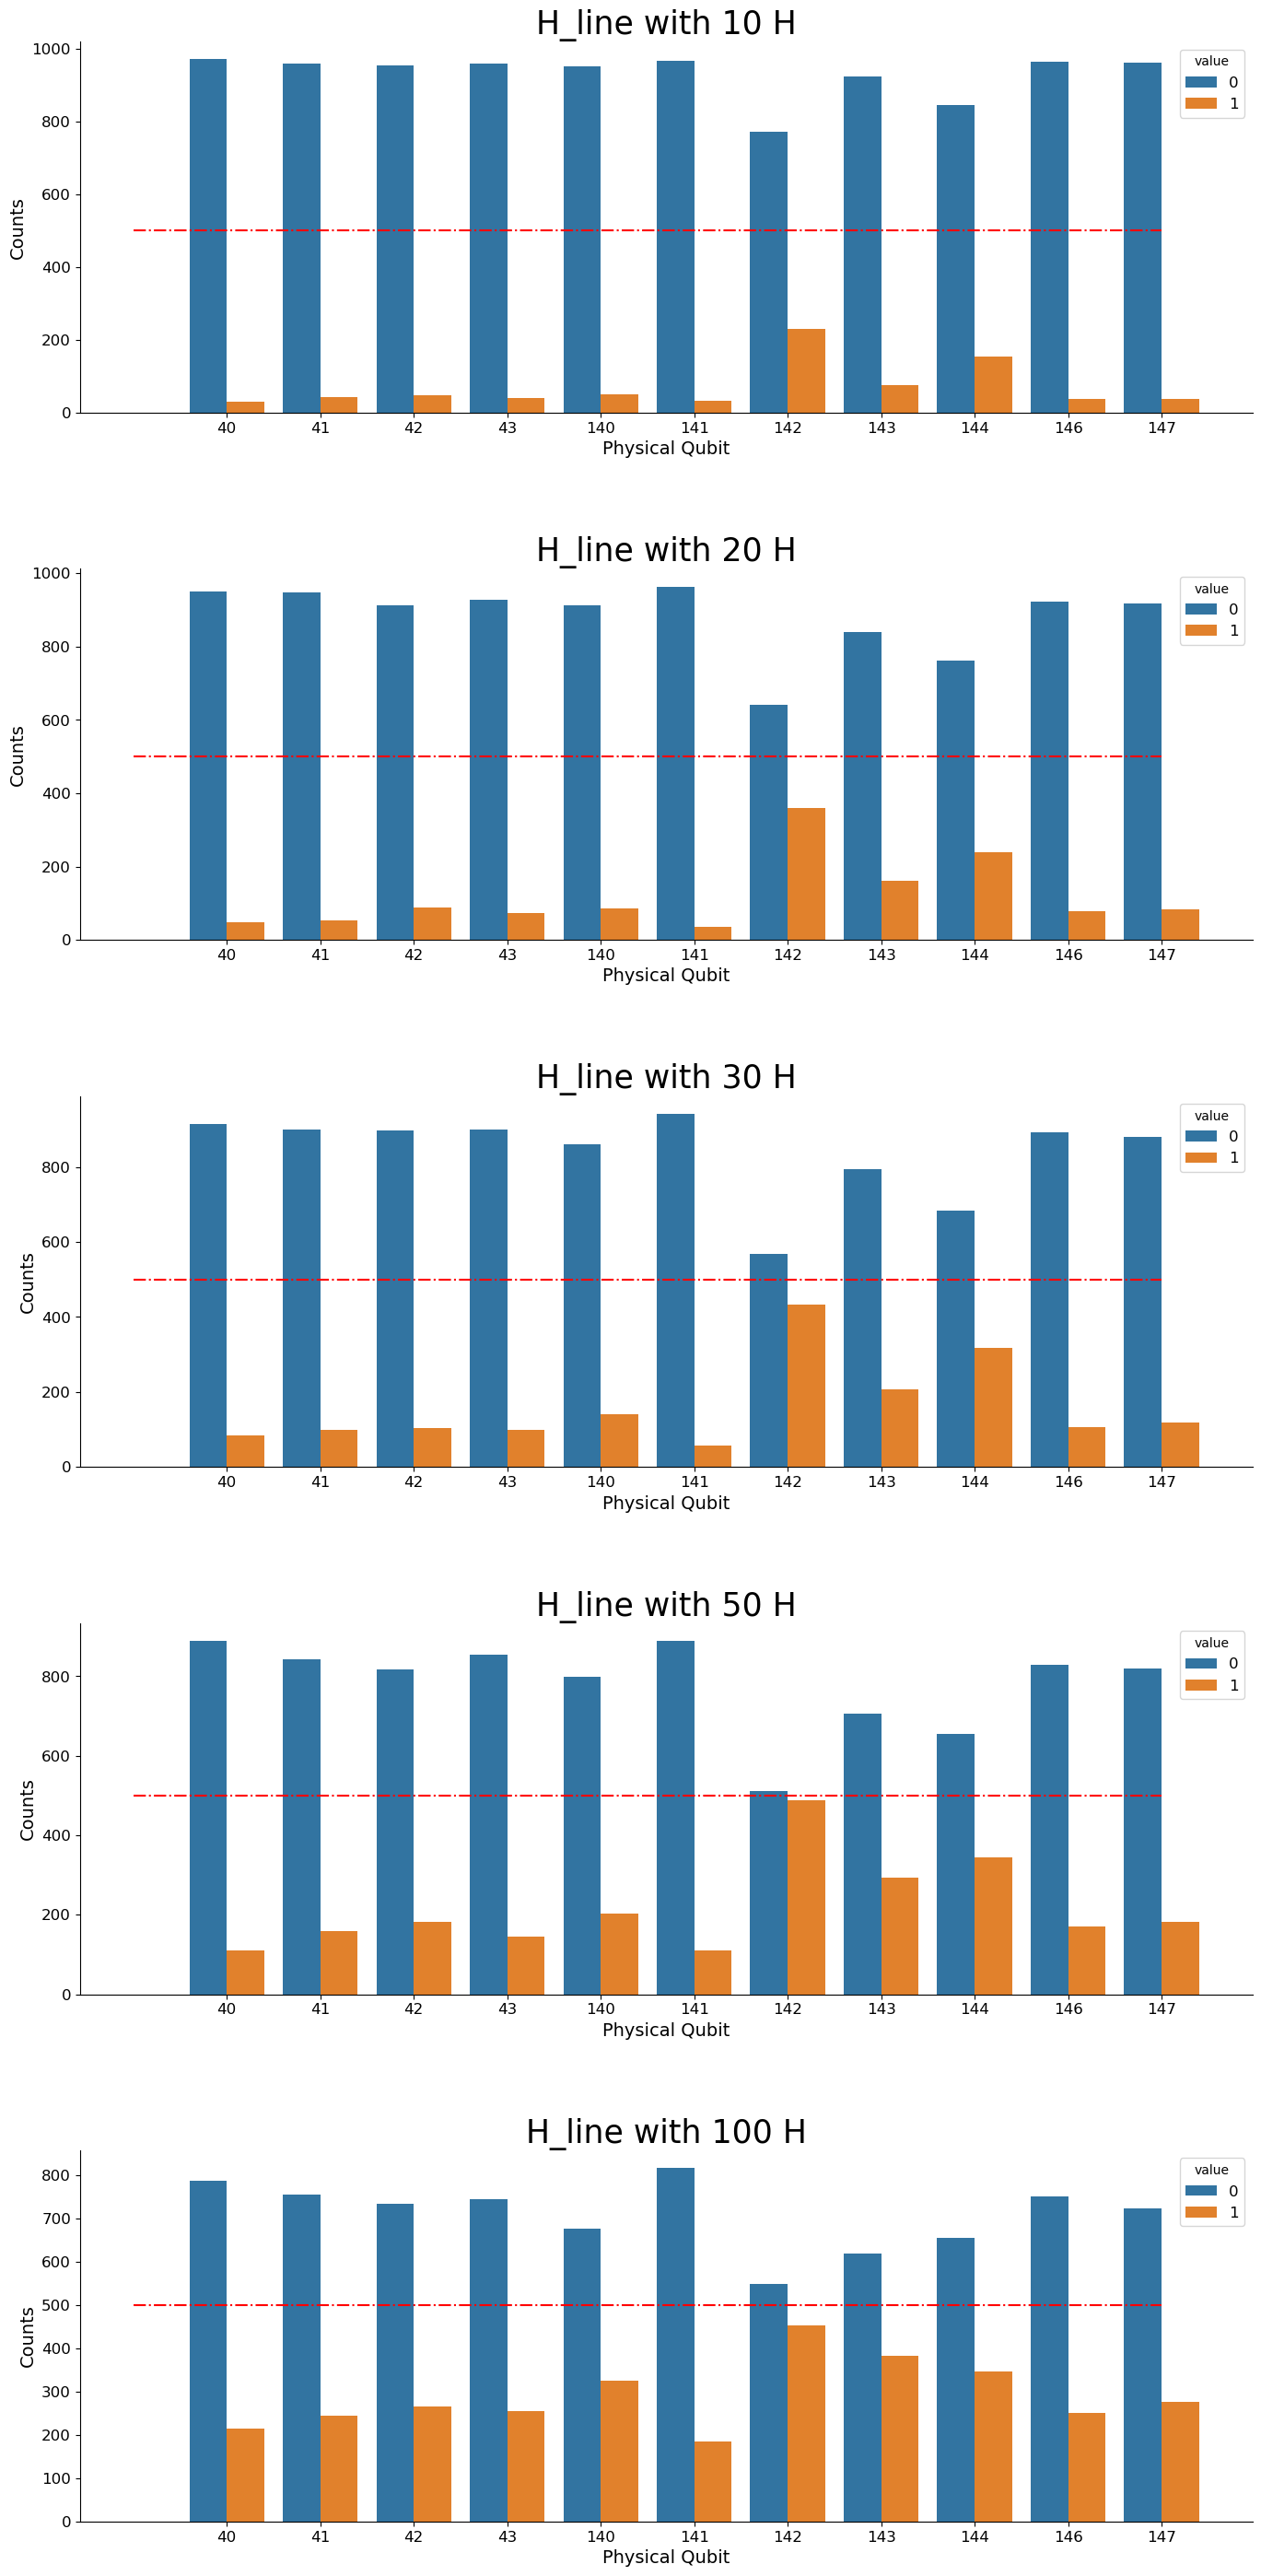

In [43]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):
    H_len = key.split("_")[-1]

    df = result_per_qubit( ls_tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'H_line with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')
    ax.set_xticklabels(qubit_mappings_sim[i].keys())
    i+=1

# Confronto con LS

In [3]:
rigetti_tasks = load_tasks("H_line_rigetti_grosso")
rigetti_scanners = [BraketTaskScanner(qtask = task) for key, task in rigetti_tasks.items()]
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]


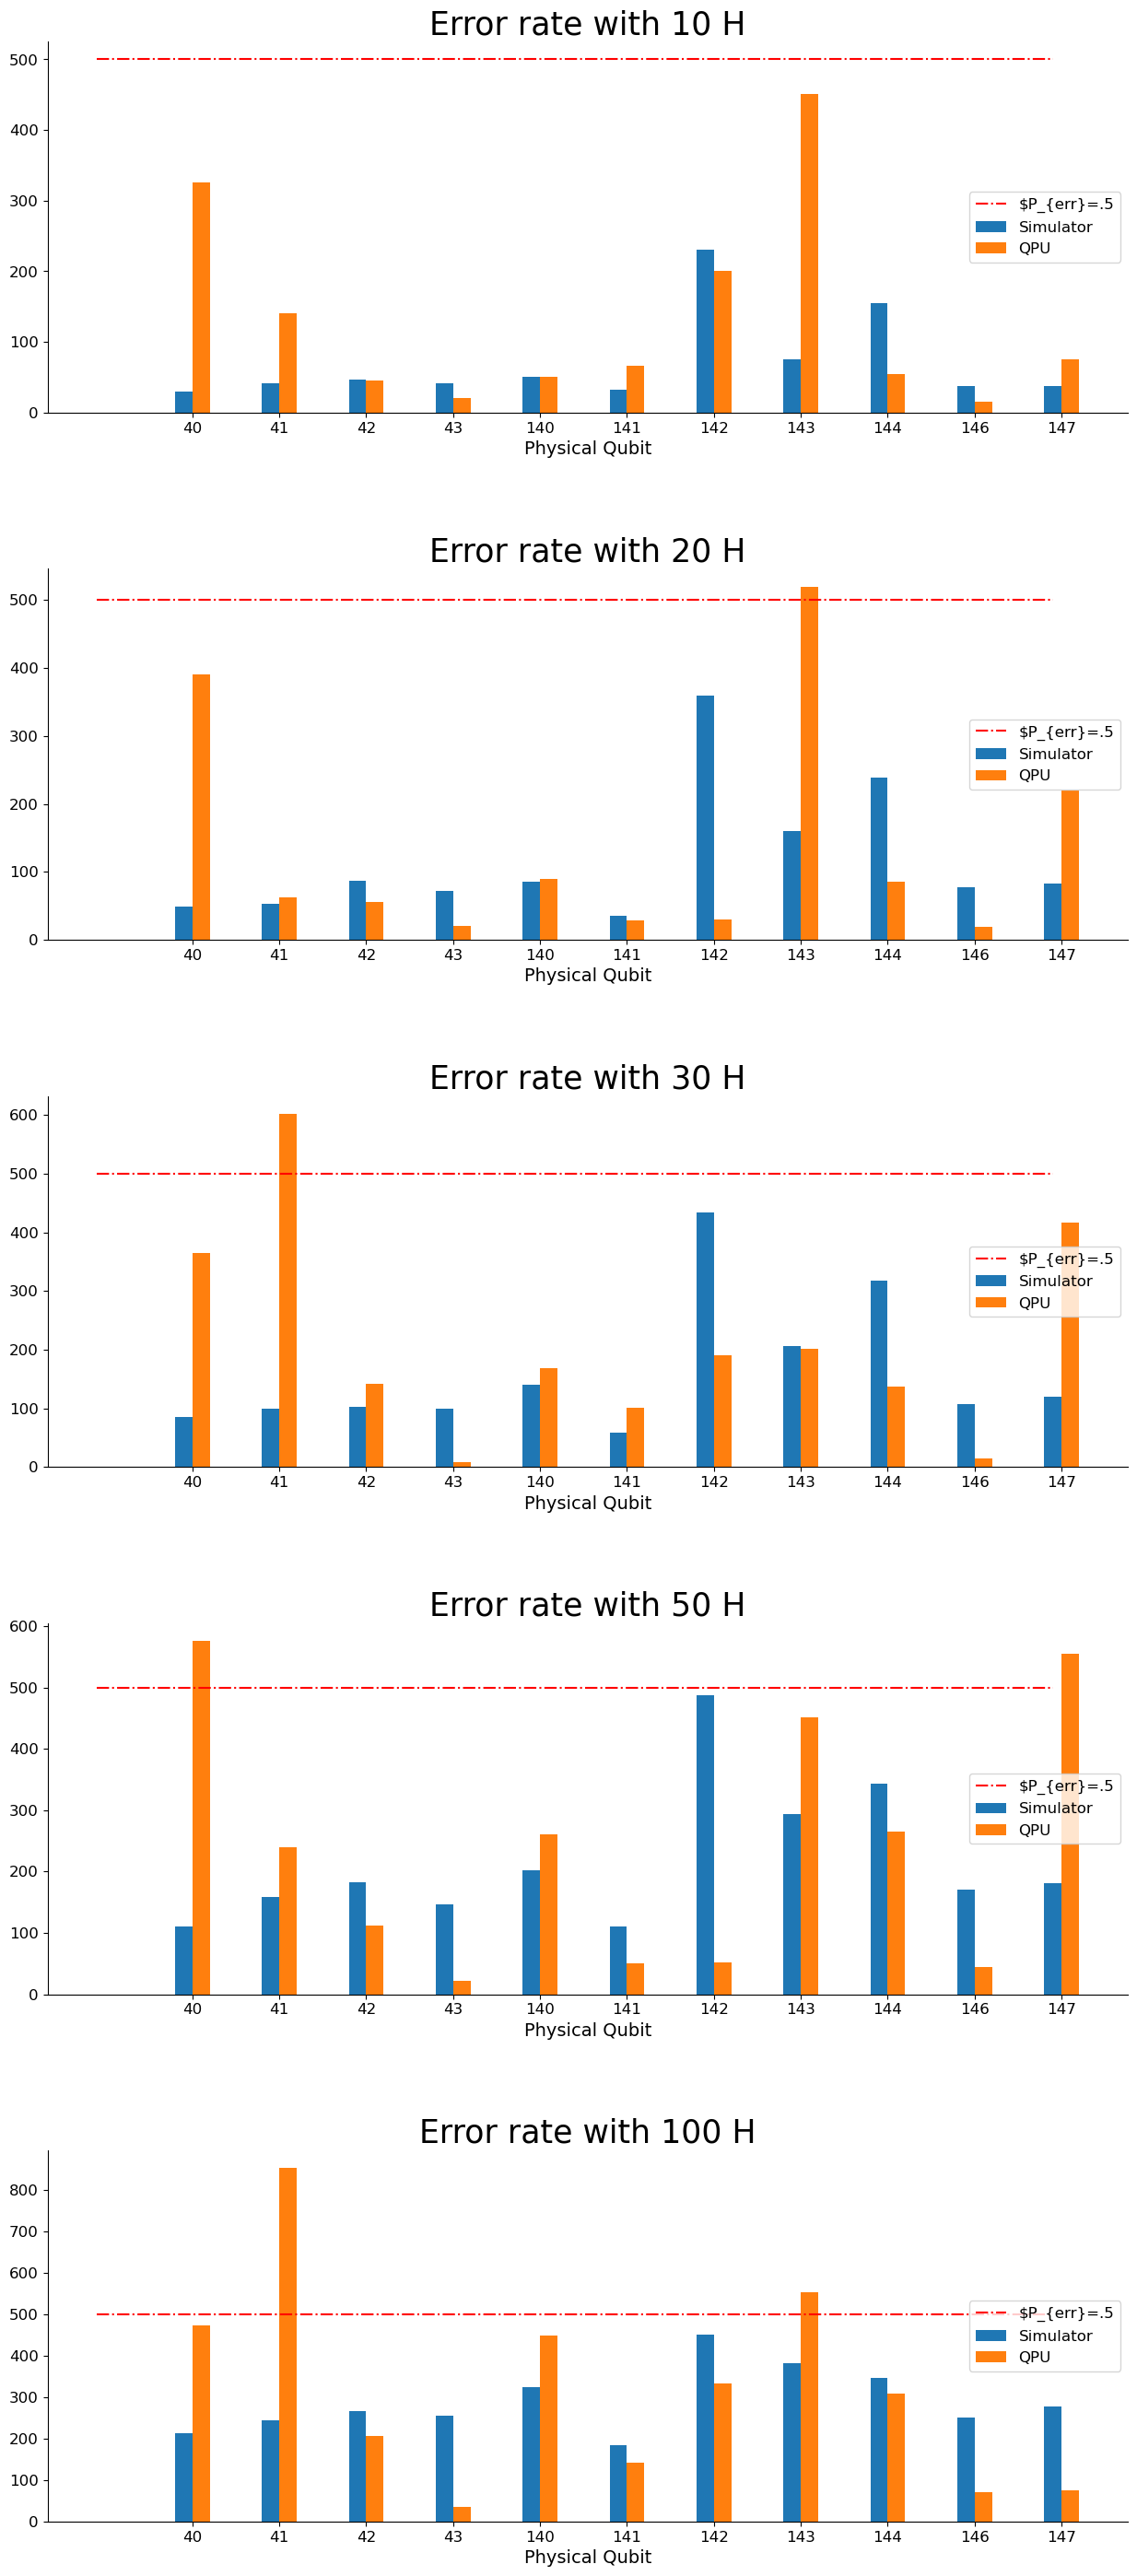

In [68]:
n_tasks = len(ls_scanners)
fig, axx = plt.subplots(n_tasks, 1, figsize=(15, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
x = np.arange(n_qubits)
bar_width = .2

for ax, rig_key,ls_key in zip(axx,rigetti_tasks,ls_tasks):

    H_len = int(rig_key.split("_")[-1][2:])

    df_sim = result_per_qubit( ls_tasks[ls_key].result(), H_len= H_len)
    df_qpu = result_per_qubit( rigetti_tasks[rig_key].result(), H_len= H_len)

    ax.bar(x, df_sim.counts[df_sim.value == '1'],
            width=bar_width,
           label = 'Simulator')
    
    ax.bar(x+bar_width, df_qpu.counts[df_qpu.value == '1'],
            width=bar_width,
           label = 'QPU')
    #plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'Error rate with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red',label='$P_{err}=.5')
    ax.set_xticks(x + bar_width/2 )
    ax.set_xticklabels([qubit_mappings[i][x] for x in range(n_qubits)])
    
    ax.legend(loc='center right')
    i+=1